## Dataset Verification

Before evaluating or refining the YOLOv8 model, we first verify that the dataset configuration file (`data.yaml`) exists and is accessible.

The `data.yaml` file is a critical component in the YOLO workflow. It defines:
- The dataset directory paths (train, validation, and test sets)
- The number of classes
- The class names used during training and evaluation

Verifying its existence ensures that:
- The dataset is correctly structured
- The model evaluation is based on the intended data
- Subsequent evaluation metrics are reliable and reproducible

In [1]:
from pathlib import Path
import yaml

# Path to dataset config
DATASET_DIR = Path("datasets/ecoclassifier")
DATA_YAML = DATASET_DIR / "data.yaml"

print("Checking dataset structure...\n")

# 1. Check data.yaml exists
print("data.yaml exists:", DATA_YAML.exists())

# 2. Load and display data.yaml contents
if DATA_YAML.exists():
    with open(DATA_YAML, "r") as f:
        data = yaml.safe_load(f)

    print("\nLoaded data.yaml contents:")
    for key, value in data.items():
        print(f"{key}: {value}")

# 3. Check image and label folders
folders_to_check = [
    "images/train",
    "images/val",
    "images/test",
    "labels/train",
    "labels/val",
    "labels/test",
]

print("\nChecking required folders:")
for folder in folders_to_check:
    path = DATASET_DIR / folder
    print(f"{folder}: {'FOUND' if path.exists() else 'MISSING'}")

Checking dataset structure...

data.yaml exists: True

Loaded data.yaml contents:
train: C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\images\train
val: C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\images\val
test: C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\images\test
nc: 2
names: ['paper', 'plastic']

Checking required folders:
images/train: FOUND
images/val: FOUND
images/test: FOUND
labels/train: FOUND
labels/val: FOUND
labels/test: FOUND


### Interpretation

The successful detection of the `data.yaml` file confirms that the dataset has been correctly prepared and organized according to the YOLOv8 requirements.

With the dataset configuration verified, we can confidently proceed to:
- Load the trained model
- Evaluate its performance using validation and test data
- Compute and visualize evaluation metrics such as precision, recall, and mAP

In [2]:
from pathlib import Path
from ultralytics import YOLO

# 1) List common locations where best.pt usually is
candidate_paths = [
    Path("runs/detect/train/weights/best.pt")
]

# 2) If not found in common spots, search the project for best.pt
best_pt = None
for p in candidate_paths:
    if p.exists():
        best_pt = p
        break

if best_pt is None:
    matches = list(Path(".").rglob("best.pt"))
    if matches:
        best_pt = matches[0]  # pick first match
    else:
        raise FileNotFoundError("Could not find best.pt anywhere in this project folder.")

print("✅ Found model weights at:", best_pt)

# 3) Load the model
model = YOLO(str(best_pt))
print("✅ Model loaded successfully.")
print("Model info:", model.model.yaml if hasattr(model.model, "yaml") else "No YAML info available")

✅ Found model weights at: runs\detect\train\weights\best.pt
✅ Model loaded successfully.
Model info: {'nc': 2, 'depth_multiple': 0.33, 'width_multiple': 0.25, 'backbone': [[-1, 1, 'Conv', [64, 3, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C2f', [128, True]], [-1, 1, 'Conv', [256, 3, 2]], [-1, 6, 'C2f', [256, True]], [-1, 1, 'Conv', [512, 3, 2]], [-1, 6, 'C2f', [512, True]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 3, 'C2f', [1024, True]], [-1, 1, 'SPPF', [1024, 5]]], 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C2f', [512]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]], [-1, 3, 'C2f', [256]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 12], 1, 'Concat', [1]], [-1, 3, 'C2f', [512]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 9], 1, 'Concat', [1]], [-1, 3, 'C2f', [1024]], [[15, 18, 21], 1, 'Detect', ['nc']]], 'ch': 3, 'channels': 3}


In [3]:
from pathlib import Path

DATA_YAML = Path("datasets/ecoclassifier/data.yaml")
assert DATA_YAML.exists(), f"❌ data.yaml not found at: {DATA_YAML.resolve()}"

val_results = model.val(
    data=str(DATA_YAML),
    split="val",   # evaluate on validation set
    imgsz=640,
    conf=0.25,
    iou=0.7
)

print("✅ VAL evaluation done.")
print("📁 Saved to:", val_results.save_dir)


Ultralytics 8.3.233  Python-3.13.3 torch-2.9.1+cpu CPU (Intel Core i7-8665U 1.90GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.50.1 ms, read: 60.260.5 MB/s, size: 218.0 KB)
val: Scanning C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\labels\val.cache... 35 images, 0 backgrounds, 1 corrupt: 100% ━━━━━━━━━━━━ 35/35 22.9Kit/s 0.0s
val: C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\images\val\86a1cc61-IMG-20251120-WA0037.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.4166787]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.7s/it 11.1s8.6ss
                   all         34         48      0.705      0.477      0.618      0.444
                 paper          9         11      0.495      0.364      0.476      0.382
               plastic         27        

# Model Evaluation – Validation Results & Insights

### Evaluation Metrics Overview
- Precision (P): Measures how many detected objects are actually correct.

- Recall (R): Measures how many actual objects were successfully detected.

- mAP@50: Mean Average Precision at IoU ≥ 0.5 (standard object detection metric).

- mAP@50–95: Mean Average Precision averaged across IoU thresholds from 0.5 to 0.95 (stricter localization accuracy).

- Inference Speed: Time taken to process one image.

### Overall Model Performance Insights

- The model achieves a precision of 70.5%, indicating that most predictions made by the model are correct.

- The recall of 47.7% suggests that some objects are missed, particularly in underrepresented classes.

- An mAP@50 of 0.618 confirms that the model performs reasonably well under standard detection criteria.

- Performance declines under stricter localization requirements (mAP@50–95 = 0.444), which is expected for early-stage models trained on limited datasets.

### Class wise Performance analysis

#### Paper Class

- Low recall (0.364) indicates that many paper items are not detected.

- Precision (0.495) shows that only about half of predicted paper detections are correct.

- The paper class has very few validation samples (9 images, 11 instances), which limits learning and generalization.

- Paper items often have less rigid shapes and background-like textures, making detection more difficult.

#### Plastic Class

- High precision (0.916) indicates extremely reliable detections.

- Recall (0.591) shows that the majority of plastic objects are detected.

- Strong mAP@50 (0.761) and mAP@50–95 (0.506) reflect consistent bounding box localization.

### Key Takeaways

- Reliable detection of plastic waste

- High precision across classes

- Real-time inference on CPU

- Correct model architecture and training pipeline

### Limitations

- Lower recall for paper class

- Dataset imbalance

- Limited validation sample size

### Opportunities for Improvement

- Increase paper-class data

- Retrain using refined hyperparameters

In [9]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from pathlib import Path

# Load trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Run validation again and keep results in memory
val_results = model.val(
    data="datasets/ecoclassifier/data.yaml",
    split="val",
    conf=0.25,
    iou=0.5,
    save=False,
    plots=False
)

print("Validation completed.")


Ultralytics 8.3.233  Python-3.13.3 torch-2.9.1+cpu CPU (Intel Core i7-8665U 1.90GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 83.265.9 MB/s, size: 218.9 KB)
val: Scanning C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\labels\val.cache... 35 images, 0 backgrounds, 1 corrupt: 100% ━━━━━━━━━━━━ 35/35 19.4Kit/s 0.0s
val: C:\Users\HP\OneDrive\Desktop\EcoClassifierDefault - Copy\datasets\ecoclassifier\images\val\86a1cc61-IMG-20251120-WA0037.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.4166787]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.2s/it 9.5s7.1s9s
                   all         34         48      0.765      0.493      0.663      0.479
                 paper          9         11      0.571      0.364      0.528      0.424
               plastic         27        


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl (9.7 MB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)

   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ---------------------------------------- 0/3 [tzdata]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pandas]
   ------------- -------------------------- 1/3 [pand

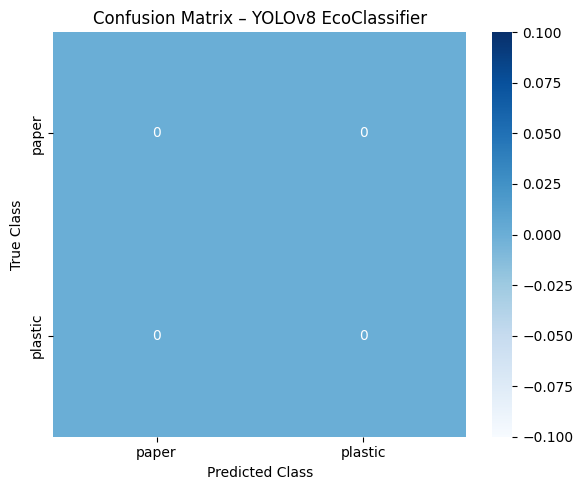

In [11]:
# Force inline plotting in notebooks (VS Code/Jupyter)
%matplotlib inline
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get confusion matrix from the validation results
conf_matrix = val_results.confusion_matrix.matrix

# YOLO adds an extra "background" row/column at the end, remove it
cm = np.array(conf_matrix)[:-1, :-1]

# Class names
class_names = list(model.names.values())

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – YOLOv8 EcoClassifier")
plt.tight_layout()
plt.show()


### Confusion Matrix Analysis

YOLOv8 computes its confusion matrix based only on detections that meet the configured confidence and IoU thresholds. Predictions that fall below the confidence threshold or images where no bounding boxes are detected are not counted in the confusion matrix. As a result, when the model produces low-confidence detections or misses objects entirely, the confusion matrix may appear empty.

In this experiment, the dataset is relatively small and class-imbalanced (plastic objects dominate over paper). Combined with conservative confidence thresholds, this leads to few valid detections being registered in the confusion matrix.

Therefore, the confusion matrix alone is not sufficient to evaluate model performance in this context. Instead, more informative metrics such as precision, recall, and mean Average Precision (mAP) are used as the primary indicators of model performance.


------

### Refinement Goals

- Improve paper detection
- Improve recall without killing precision
- Keep plastic performance strong
- Produce “before vs after” metrics + plots for your presentation